This based off of the tutorial from scanpy using pbmc 6k.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc6k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

# Imports

In [4]:
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess


# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.sparse import coo_matrix
import collections
import scanpy as sc


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import sklearn as sk

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

import pickle
import gzip
from pathlib import Path


# Parameters

In [5]:
# parameters

aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_pbmc_data/"
cybersort_path = f"{os.getcwd()}/../data/single_cell_data/cybersort_pbmc/"
data_path = f"{os.getcwd()}/../data/single_cell_data/pbmc6k/hg19/"
scpred_path = f"{os.getcwd()}/../results/single_cell_data/pbmc_cell_labels/"


num_cells_vec = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
num_cells_vec = [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]


#####################
### set the study ###
#####################

res_name = "pbmc6k-tcell"
in_name = "pbmc6k"
results_file = f"{data_path}/{res_name}.h5ad"



# Load and Process data

### Read in data and metadata

In [6]:
# read in the data
adata = sc.read_10x_mtx(
    data_path,                               # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`



In [7]:
# add metadata

# add metadata
meta_data = pd.read_csv(f"{scpred_path}/{in_name}_scpred.tsv", sep="\t", index_col='code')
barcodes = pd.read_csv(f"{data_path}/barcodes.tsv", header=None, names=['code'])
meta_df = barcodes.join(other=meta_data, on=['code'], how='left', sort=False)


adata.obs['scpred_CellType'] = meta_df['scpred_prediction'].tolist()


### Preprocess

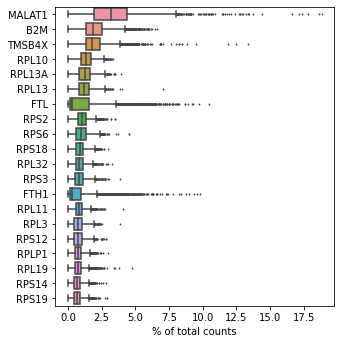

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [9]:
# filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'scpred_CellType' as categorical


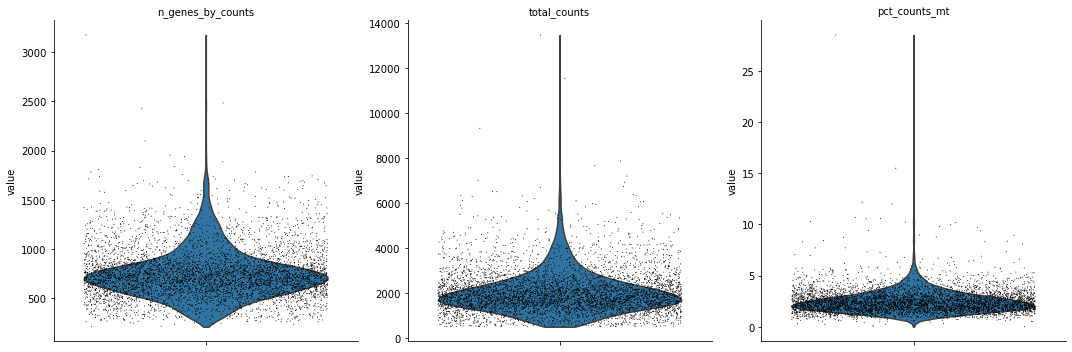

In [10]:
# remove genes with high mitochondrial content
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

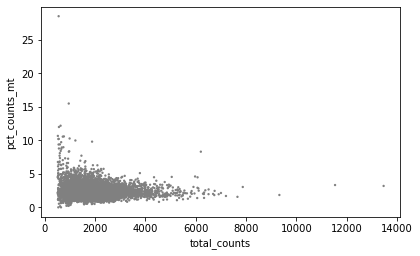

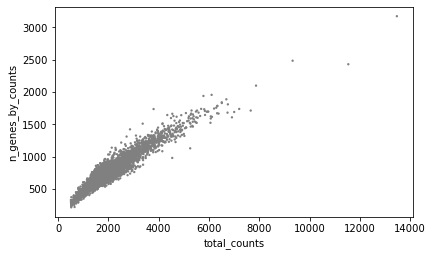

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [12]:
# slice the data based on the plots from above
# remove cells with more than 3500 genes
# remove cells with more than 10% MTgenes
adata = adata[adata.obs.n_genes_by_counts < 2000, :]
adata = adata[adata.obs.pct_counts_mt < 7, :]


# normalize to 10K counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [24]:
# remove cells that are unlabeled or unclassified
cell_type_id = adata.obs["scpred_CellType"].values
cell_type_id = np.unique(cell_type_id)
cell_type_remove = ["unassigned", "unclassified"]
cell_type_id = set(cell_type_id).difference(set(cell_type_remove))
adata = adata[adata.obs["scpred_CellType"].isin(cell_type_id)]
print(np.unique(adata.obs["scpred_CellType"].values))


['b' 'cd4' 'cd4_cd8_naive' 'cd8' 'mono14' 'mono16' 'nk' 'other']


In [14]:
# group together cell types that are not very frequent

all_vals = adata.obs["scpred_CellType"].to_list()
all_vals = np.char.replace(all_vals, 'adc', 'other')
all_vals = np.char.replace(all_vals, 'pdc', 'other')
all_vals = np.char.replace(all_vals, 'mk', 'other')
all_vals = np.char.replace(all_vals, 'hsc', 'other')
adata.obs["scpred_CellType"] = all_vals



Trying to set attribute `.obs` of view, copying.


In [15]:
from collections import Counter

Counter(all_vals)

Counter({'cd4_cd8_naive': 1304,
         'mono14': 1014,
         'cd8': 661,
         'b': 690,
         'other': 125,
         'nk': 299,
         'cd4': 693,
         'mono16': 327})

In [ ]:
# write out data for BP and cibersort

# nonperturbed means we sample monocytes from mono16
mono16 = ["other", "mono16", "b", "cd4_cd8_naive", "cd4", "cd8", "nk"]
sig_nonperturb = adata[adata.obs["scpred_CellType"].isin(mono16)]

all_vals = sig_nonperturb.obs["scpred_CellType"].to_list()
all_vals = np.char.replace(all_vals, 'mono16', 'mono')
sig_nonperturb.obs["scpred_CellType"] = all_vals

dense_matrix = sig_nonperturb.X.todense()

sc_profile_file = os.path.join(aug_data_path, f"{res_name}_sig.pkl")
sc_profile_path = Path(sc_profile_file)

dense_df = pd.DataFrame(dense_matrix, columns = sig_nonperturb.var['gene_ids'])
dense_df.insert(loc=0, column='scpred_CellType', value=sig_nonperturb.obs["scpred_CellType"].to_list())

pickle.dump( dense_df, open( sc_profile_path, "wb" ) )


Trying to set attribute `.obs` of view, copying.


In [ ]:
dense_matrix.shape

(2575, 13714)

In [22]:
perturb_vec = ["other", "mono16", "b", "cd4_cd8_naive", "cd4", "cd8", "nk"]
nonperturb_vec = ["other", "mono14", "b", "cd4_cd8_naive", "cd4", "cd8", "nk"]

len(perturb_vec)

7

# Plot Data

         Falling back to preprocessing with `sc.pp.pca` and default params.


OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'scpred_CellType' as categorical


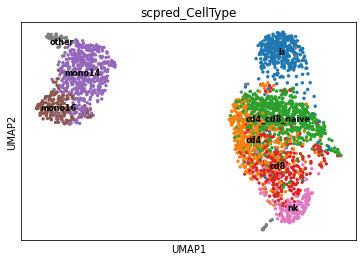

In [ ]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)

# plot some markers of the RAW data
sc.pl.umap(adata, legend_loc='on data', color='scpred_CellType', legend_fontsize=8)


# Make Pseudobulks

In [ ]:
# set up the cell-noise perturbations
len_vector = adata.obs["scpred_CellType"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, adata.var['gene_ids'].shape[0]) for i in range(len_vector)]

# make b-cells be perturbed -- this will be used for unlabeled
cell_noise_perturb = cell_noise
cell_noise_perturb[0] = np.random.lognormal(0, 0.1, adata.var['gene_ids'].shape[0])



In [ ]:
# perturbed means we sample monocytes from mono14
mono14 = ["other", "mono14", "b", "cd4_cd8_naive", "cd4", "cd8", "nk"]
adata_perturb = adata[adata.obs["scpred_CellType"].isin(mono14)]

all_vals = adata_perturb.obs["scpred_CellType"].to_list()
all_vals = np.char.replace(all_vals, 'mono14', 'mono')
adata_perturb.obs["scpred_CellType"] = all_vals

# nonperturbed means we sample monocytes from mono16
mono16 = ["other", "mono16", "b", "cd4_cd8_naive", "cd4", "cd8", "nk"]
adata_nonperturb = adata[adata.obs["scpred_CellType"].isin(mono16)]

all_vals = adata_nonperturb.obs["scpred_CellType"].to_list()
all_vals = np.char.replace(all_vals, 'mono16', 'mono')
adata_nonperturb.obs["scpred_CellType"] = all_vals

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [ ]:
# write out the gene ids
gene_pass = adata.var['gene_ids']
gene_out_file = os.path.join(aug_data_path, f"{res_name}_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( gene_pass, open( gene_out_path, "wb" ) )

# make the cell-type specific noise


# simulate different number of cells
num_samples = 1000
for idx in range(len(num_cells_vec)):
  print(f"New Domain {idx}")
  pbmc_rep1_pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_pseudo_{idx}.pkl")
  pbmc_rep1_prop_file = os.path.join(aug_data_path, f"{res_name}_prop_{idx}.pkl")
  test_pbmc_rep1_pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_testpseudo_{idx}.pkl")
  test_pbmc_rep1_prop_file = os.path.join(aug_data_path, f"{res_name}_testprop_{idx}.pkl")

  # if unlabeled data, we need to have both perturbed and non-perturbed cell types
  # idx 0 is for testing and will be perturbed
  # idx 1-4 are not perturbed because they are labeled
  # idx 5 is ignored for now, we will make it perturbed
  # idx 6-9 are unlabeled and will have be perturbed half not be
  # so this makes idx 5,6,7 perturbed
  # idx 8,9 unperturbed
  # summary:
  # perturbed: 0,5,6,7
  # unperturb: 1,2,3,4,8,9
  # train: 1,2,3,4,6,7,8,9
  # test:  6
  # labeled: 1,2,3,4
  # unlabeled: 6,7,8,9

  perturbed_idx = np.array([0,5,6,7])
  cell_noise_choice = cell_noise
  curr_adata = adata_nonperturb
  if idx in perturbed_idx:
    cell_noise_choice = cell_noise_perturb
    curr_adata = adata_perturb

  pseudobulk_path = Path(pbmc_rep1_pseudobulk_file)
  prop_path = Path(pbmc_rep1_prop_file)
  test_pseudobulk_path = Path(test_pbmc_rep1_pseudobulk_file)
  test_prop_path = Path(test_pbmc_rep1_prop_file)

  if not pseudobulk_path.is_file(): # skip if we already generated it

    # make the pseudobulks
    num_cells = num_cells_vec[idx]
    prop_df, pseudobulks_df, test_prop_df, test_pseudobulks_df = sc_preprocess.make_prop_and_sum(curr_adata, 
                                                                            num_samples, 
                                                                            num_cells,
                                                                            use_true_prop=False,
                                                                            cell_noise=cell_noise_choice)

    # make the proportions instead of cell counts
    prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
    test_prop_df = test_prop_df.div(test_prop_df.sum(axis=1), axis=0)

    pickle.dump( prop_df, open( prop_path, "wb" ) )
    pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )

    pickle.dump( test_prop_df, open( test_prop_path, "wb" ) )
    pickle.dump( test_pseudobulks_df, open( test_pseudobulk_path, "wb" ) )


    if not np.all(np.isclose(prop_df.sum(axis=1), 1.)):
        assert False, "Proportions do not sum to 1"



New Domain 0
0
100
200
300
400
500
600
700
800
900
1000
New Domain 1
0
100
200
300
400
500
600
700
800
900
1000
New Domain 2
0
100
200
300
400
500
600
700
800
900
1000
New Domain 3
0
100
200
300
400
500
600
700
800
900
1000
New Domain 4
0
100
200
300
400
500
600
700
800
900
1000
New Domain 5
0
100
200
300
400
500
600
700
800
900
1000
New Domain 6
0
100
200
300
400
500
600
700
800
900
1000
New Domain 7
0
100
200
300
400
500
600
700
800
900
1000
New Domain 8
0
100
200
300
400
500
600
700
800
900
1000
New Domain 9
0
100
200
300
400
500
600
700
800
900
1000
